In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
data = pd.read_csv("/content/drive/MyDrive/tesla.csv")

In [3]:
def check_df(data, head=5):
    print("------------- Shape -------------")
    print(data.shape)
    print("------------- Types -------------")
    print(data.dtypes)
    print("------------- Head -------------")
    print(data.head(head))
    print("------------- Tail -------------")
    print(data.tail(head))
    print("------------- Na -------------")
    print(data.isnull().sum())
    print("------------- Quantiles -------------")

In [5]:
# Sadece sayısal sütunları seç
numeric_df = data.select_dtypes(include=['number'])
print(numeric_df.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

                    0.00           0.05          0.50          0.95  \
Open           16.139999      23.384999  2.130350e+02  3.519100e+02   
High           16.629999      24.022501  2.167450e+02  3.567500e+02   
Low            14.980000      22.867499  2.088700e+02  3.460250e+02   
Close          15.800000      23.565000  2.129600e+02  3.511675e+02   
Adj Close      15.800000      23.565000  2.129600e+02  3.511675e+02   
Volume     118500.000000  633825.000000  4.578400e+06  1.476090e+07   

                   0.99          1.00  
Open       4.235790e+02  6.736900e+02  
High       4.284705e+02  7.861400e+02  
Low        4.122865e+02  6.735200e+02  
Close      4.243455e+02  7.800000e+02  
Adj Close  4.243455e+02  7.800000e+02  
Volume     2.459959e+07  4.706500e+07  


In [6]:
check_df(data)

------------- Shape -------------
(2416, 7)
------------- Types -------------
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object
------------- Head -------------
         Date       Open   High        Low      Close  Adj Close    Volume
0  2010-06-29  19.000000  25.00  17.540001  23.889999  23.889999  18766300
1  2010-06-30  25.790001  30.42  23.299999  23.830000  23.830000  17187100
2  2010-07-01  25.000000  25.92  20.270000  21.959999  21.959999   8218800
3  2010-07-02  23.000000  23.10  18.709999  19.200001  19.200001   5139800
4  2010-07-06  20.000000  20.00  15.830000  16.110001  16.110001   6866900
------------- Tail -------------
            Date        Open        High         Low       Close   Adj Close  \
2411  2020-01-28  568.489990  576.809998  558.080017  566.900024  566.900024   
2412  2020-01-29  575.690002  589.799988  567.429993  580.989990  580.989990   
2413 

In [7]:
# Tarih sütununu datetime formatına çevirme
data["Date"] = pd.to_datetime(data["Date"])

In [8]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


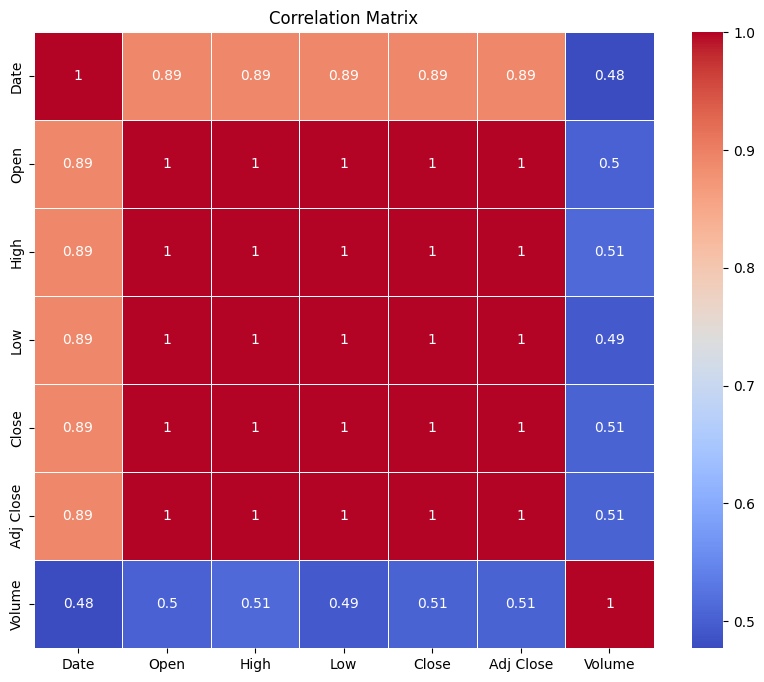

In [9]:
# Veri sütunları arasındaki ilişkiyi görselleştirme
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [14]:
# Tüm fiyat verilerini içeren yeni bir dataframe oluşturma
tesla_df = data[["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]]

In [15]:
tesla_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [16]:
print("minumum tarih: ", tesla_df["Date"].min())
print("maksimum tarih: ", tesla_df["Date"].max())

minumum tarih:  2010-06-29 00:00:00
maksimum tarih:  2020-02-03 00:00:00


In [17]:
# Tarih sütununu indeks olarak ayarlama
tesla_df.index = tesla_df["Date"]
tesla_df.drop("Date", axis=1, inplace=True)


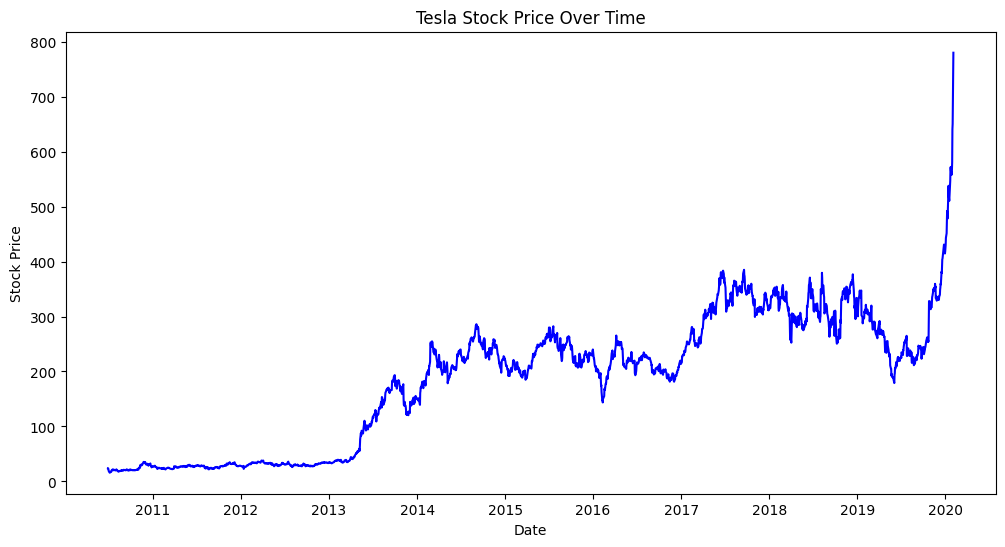

In [18]:
# Zaman serisini görselleştirme
plt.figure(figsize=(12, 6))
plt.plot(tesla_df['Close'], color='blue')
plt.ylabel('Stock Price')
plt.title('Tesla Stock Price Over Time')
plt.xlabel('Date')
plt.show()

In [19]:
# Verinin hareketli ortalamasını hesaplama ve görselleştirme
tesla_df['Close_MA30'] = tesla_df['Close'].rolling(window=30).mean()

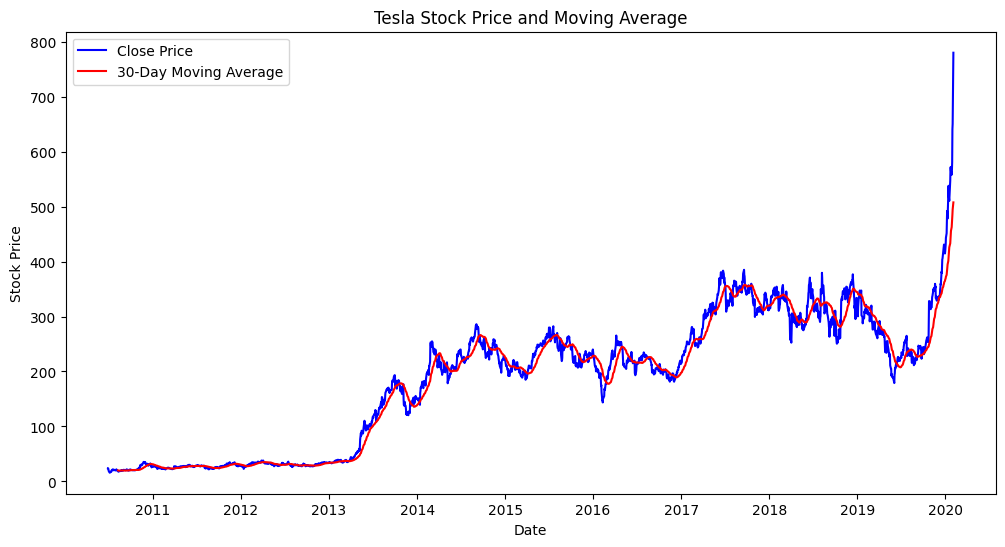

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(tesla_df['Close'], label='Close Price', color='blue')
plt.plot(tesla_df['Close_MA30'], label='30-Day Moving Average', color='red')
plt.ylabel('Stock Price')
plt.title('Tesla Stock Price and Moving Average')
plt.xlabel('Date')
plt.legend()
plt.show()

In [21]:
# Korelasyon hesaplama
corr_matrix = tesla_df.corr()
print("Correlation Matrix:\n", corr_matrix)

Correlation Matrix:
                 Open      High       Low     Close  Adj Close    Volume  \
Open        1.000000  0.999425  0.999575  0.998886   0.998886  0.501762   
High        0.999425  1.000000  0.999389  0.999640   0.999640  0.512944   
Low         0.999575  0.999389  1.000000  0.999447   0.999447  0.493496   
Close       0.998886  0.999640  0.999447  1.000000   1.000000  0.505169   
Adj Close   0.998886  0.999640  0.999447  1.000000   1.000000  0.505169   
Volume      0.501762  0.512944  0.493496  0.505169   0.505169  1.000000   
Close_MA30  0.985392  0.984500  0.984629  0.983950   0.983950  0.485591   

            Close_MA30  
Open          0.985392  
High          0.984500  
Low           0.984629  
Close         0.983950  
Adj Close     0.983950  
Volume        0.485591  
Close_MA30    1.000000  


In [22]:
# En yüksek korelasyona sahip ilk 3 çift sütunu bulma
corr_pairs = corr_matrix.unstack()
sorted_pairs = corr_pairs.sort_values(kind="quicksort")
high_corr = sorted_pairs[(sorted_pairs) != 1].sort_values(ascending=False)
print("Top 3 Highly Correlated Pairs:\n", high_corr[0:6])

Top 3 Highly Correlated Pairs:
 Close      High         0.999640
High       Adj Close    0.999640
           Close        0.999640
Adj Close  High         0.999640
Open       Low          0.999575
Low        Open         0.999575
dtype: float64


In [23]:
# Veriyi numpy array'e çevirme
tesla_df_values = tesla_df[['Close']].values

In [24]:
# Veriyi float32 formatına çevirme
tesla_df_values = tesla_df_values.astype('float32')

In [25]:
# Veriyi eğitim ve test setlerine ayırma
def split_data(dataframe, test_size):
    pos = int(round(len(dataframe) * (1-test_size)))
    train = dataframe[:pos]
    test = dataframe[pos:]
    return train, test, pos

In [26]:
train, test, pos = split_data(tesla_df_values, 0.20)
print(train.shape, test.shape)

(1933, 1) (483, 1)


In [27]:
# Veriyi normalize etme
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

In [28]:
# Feature ve target setlerini oluşturma
def create_features(data, lookback):
    X, Y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, 0])
        Y.append(data[i, 0])
    return np.array(X), np.array(Y)

In [29]:
lookback = 20
X_train, y_train = create_features(scaled_train, lookback)
X_test, y_test = create_features(scaled_test, lookback)

In [30]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1913, 20) (1913,) (463, 20) (463,)


In [31]:
# 3D şekline yeniden boyutlandırma
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

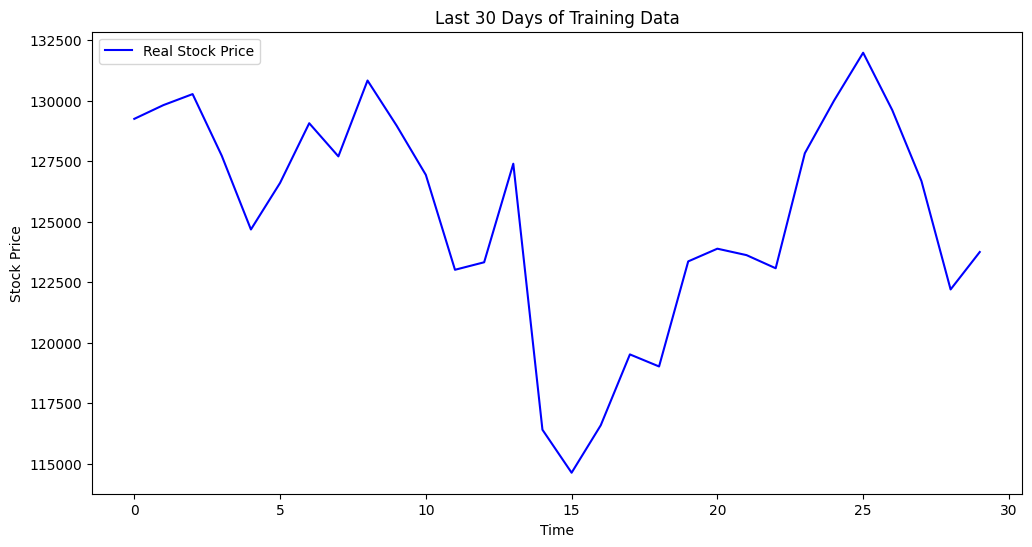

In [32]:
# Eğitim verisi için son 30 günün fiyatlarını görselleştirme
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(train[-30:]), label='Real Stock Price', color='blue')
plt.title('Last 30 Days of Training Data')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

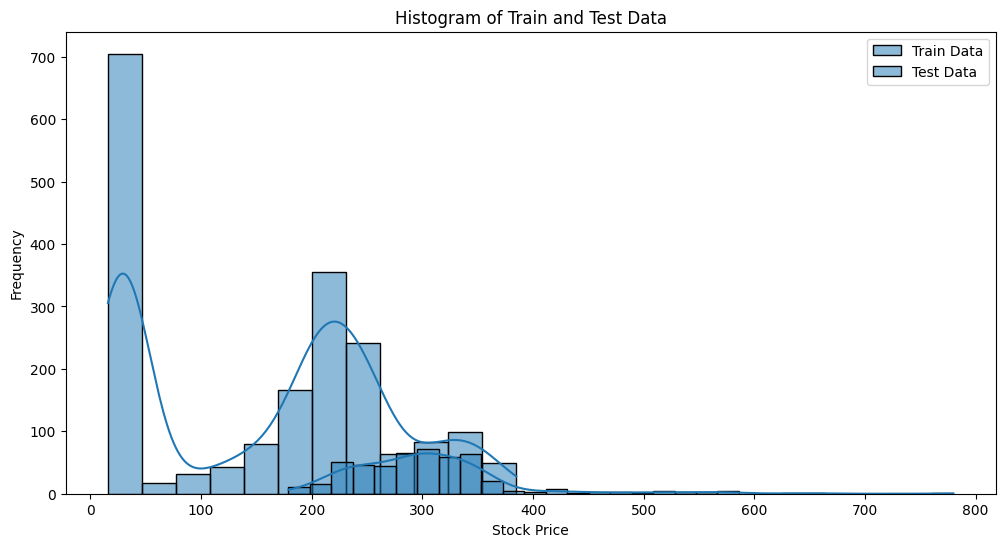

In [33]:
# Eğitim ve test verilerinin histogramlarını çizme
plt.figure(figsize=(12, 6))
sns.histplot(train, kde=True, color='blue', label='Train Data')
sns.histplot(test, kde=True, color='red', label='Test Data')
plt.title('Histogram of Train and Test Data')
plt.xlabel('Stock Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [34]:
model = Sequential()
# İlk LSTM katmanı ve Dropout
model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(lookback, 1)))
model.add(Dropout(0.2))

# İkinci LSTM katmanı ve Dropout
model.add(LSTM(units=50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

# Üçüncü LSTM katmanı ve Dropout
model.add(LSTM(units=50, activation='relu'))
model.add(Dropout(0.2))

# Çıkış katmanı
model.add(Dense(1))


In [35]:
# Modelin yapısını gözlemleme
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 20, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 20, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 20, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [36]:
# Modelin optimizasyon ve değerlendirme parametrelerinin tanımlanması
model.compile(optimizer='adam', loss='mean_squared_error')


In [37]:
# Aşırı öğrenmenin önüne geçmek için early stopping ayarı
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=2, mode='min'),
    ModelCheckpoint(filepath='mymodel.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=2)
]


In [38]:
# Modelin eğitilmesi
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    shuffle=False
)

Epoch 1/100
59/60 [============================>.] - ETA: 0s - loss: 0.0166
Epoch 1: val_loss improved from inf to 0.01350, saving model to mymodel.h5
60/60 [==============================] - 6s 39ms/step - loss: 0.0165 - val_loss: 0.0135
Epoch 2/100
 5/60 [=>............................] - ETA: 1s - loss: 0.0794

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


59/60 [============================>.] - ETA: 0s - loss: 0.0494
Epoch 2: val_loss did not improve from 0.01350
60/60 [==============================] - 2s 35ms/step - loss: 0.0489 - val_loss: 0.0165
Epoch 3/100
60/60 [==============================] - ETA: 0s - loss: 0.0190
Epoch 3: val_loss did not improve from 0.01350
60/60 [==============================] - 3s 51ms/step - loss: 0.0190 - val_loss: 0.0181
Epoch 4/100
60/60 [==============================] - ETA: 0s - loss: 0.0066
Epoch 4: val_loss did not improve from 0.01350
60/60 [==============================] - 2s 33ms/step - loss: 0.0066 - val_loss: 0.0145
Epoch 5/100
59/60 [============================>.] - ETA: 0s - loss: 0.0056
Epoch 5: val_loss improved from 0.01350 to 0.01128, saving model to mymodel.h5
60/60 [==============================] - 2s 30ms/step - loss: 0.0057 - val_loss: 0.0113
Epoch 6/100
59/60 [============================>.] - ETA: 0s - loss: 0.0058
Epoch 6: val_loss improved from 0.01128 to 0.01081, saving m

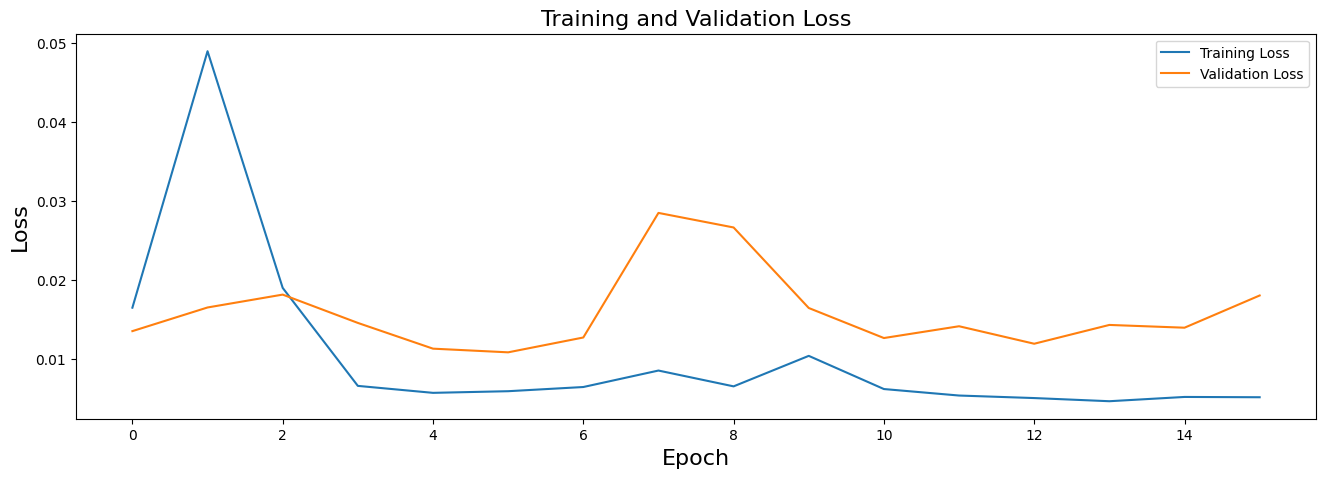

In [39]:
# Eğitim ve doğrulama kayıplarının grafiği
plt.figure(figsize=(16, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Training and Validation Loss', fontsize=16)
plt.show()

In [40]:
# Modelin değerlendirilmesi
loss = model.evaluate(X_test, y_test, batch_size=32)
print("\nTest Loss: {:.6f}".format(loss))

15/15 [==============================] - 0s 10ms/step - loss: 0.0180

Test Loss: 0.018012


In [41]:
# Tahminlerin yapılması
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

15/15 [==============================] - 0s 8ms/step


In [43]:
# Tahminlerin ölçek geri dönüşümü
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))


In [44]:
# RMSE hesaplanması
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))

In [45]:
print(f"TRAIN RMSE: {train_rmse}")
print(f"TEST RMSE: {test_rmse}")

TRAIN RMSE: 82203.140625
TEST RMSE: 122854.546875


In [47]:
# Tahmin edilen değerlerin görselleştirilmesi
train_predict_df = tesla_df.iloc[lookback:pos].copy()
train_predict_df["Predicted"] = train_predict

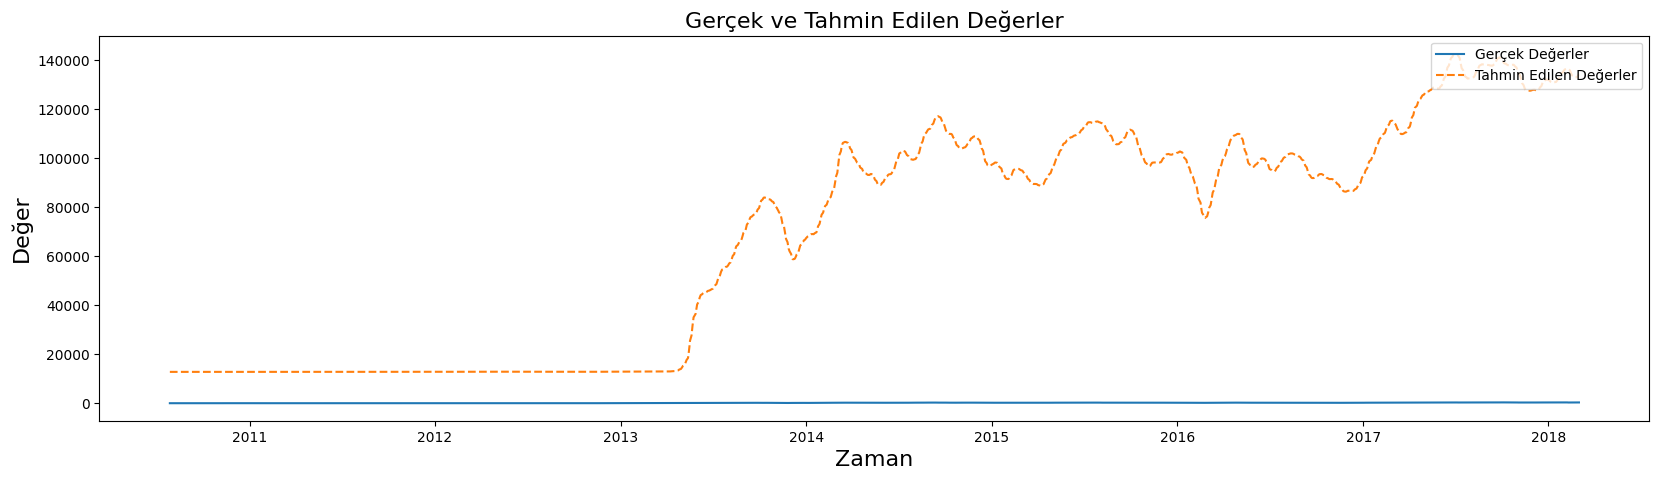

In [48]:
plt.figure(figsize=(20, 5))
plt.plot(train_predict_df.index, train_predict_df["Close"], label='Gerçek Değerler')
plt.plot(train_predict_df.index, train_predict_df["Predicted"], label='Tahmin Edilen Değerler', linestyle='--')
plt.legend(loc='upper right')
plt.xlabel('Zaman', fontsize=16)
plt.ylabel('Değer', fontsize=16)
plt.title('Gerçek ve Tahmin Edilen Değerler', fontsize=16)
plt.show()


In [49]:
# Test tahminlerinin görselleştirilmesi
test_predict_df = tesla_df.iloc[pos + lookback:].copy()
test_predict_df["Predicted"] = test_predict

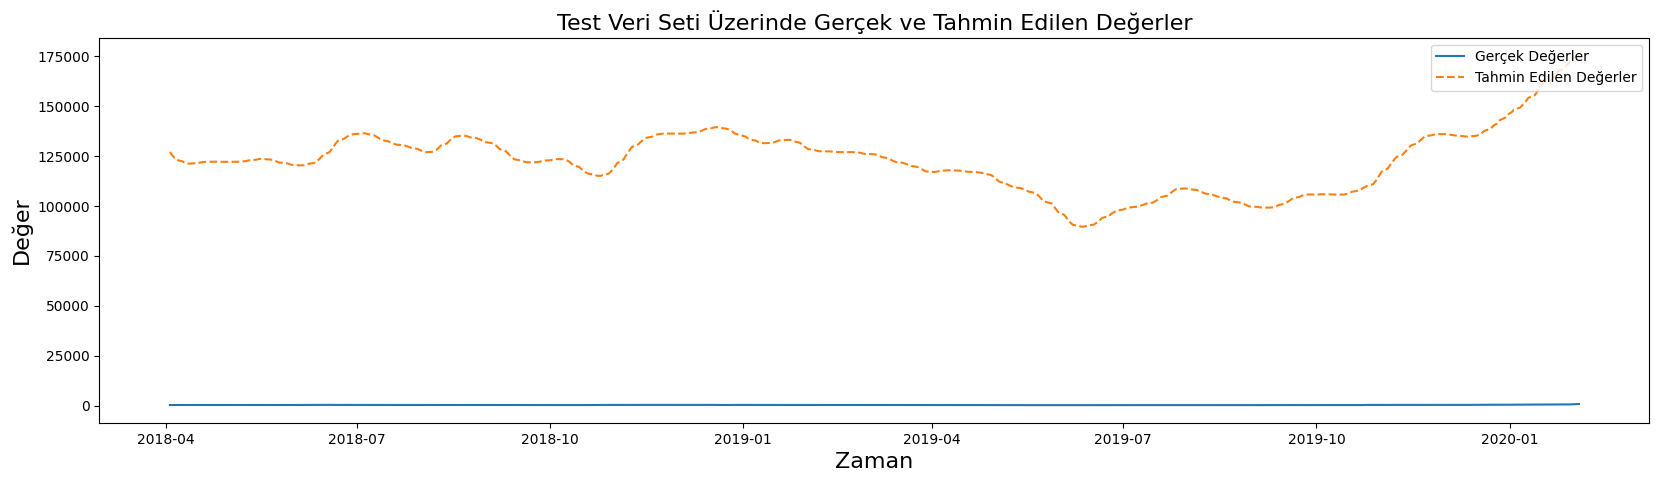

In [50]:
plt.figure(figsize=(20, 5))
plt.plot(test_predict_df.index, test_predict_df["Close"], label='Gerçek Değerler')
plt.plot(test_predict_df.index, test_predict_df["Predicted"], label='Tahmin Edilen Değerler', linestyle='--')
plt.legend(loc='upper right')
plt.xlabel('Zaman', fontsize=16)
plt.ylabel('Değer', fontsize=16)
plt.title('Test Veri Seti Üzerinde Gerçek ve Tahmin Edilen Değerler', fontsize=16)
plt.show()